In [1]:
import uproot4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import os
import numpy as np
import pandas as pd
import itertools

from event_display import  build_calorimeter_section

In [2]:
pics_prefix = os.path.join("plots", "v1_")

In [3]:
from geant3_parser import build_true_answers_train_set
from geant3_parser import Geant3DataFile

def norm_func(e):
    return np.float64(np.log(e) / 11)

file_name = os.path.join('data', 'shower_geant3_new.dat')
data_file = Geant3DataFile(file_name, skip_lines=3)

events_to_read = 5000
input_data, answers, values = build_true_answers_train_set(data_file, events_to_read*2, norm_func=norm_func, rnd_shift=((-2,2), (-2,2)))

# Remove x,y

# Reshape to events x 11 x 11 x 1 form
input_data = np.reshape(input_data, (len(input_data), 11, 11, 1))  # -1 => autodetermine
answers = np.reshape(answers, (len(answers), 11, 11, 1))  # -1 => autodetermine

# Pad with 1 row and column of zeroes, so it divides by 2, events x 12 x 12 x 1 now
input_data = np.pad(input_data, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
answers = np.pad(answers, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)

#
input_first = input_data[:events_to_read]
input_second = input_data[events_to_read:]
input_merged = np.add(input_first, input_second)

answers_first = answers[:events_to_read]
answers_second = answers[events_to_read:]
answers_merged = np.add(answers_first, answers_second)

# printout shape
print(f"Inputs shape new = {np.shape(input_data)}")

Time open 0.38199687004089355
Time split 0.3020193576812744
Inputs shape new = (10000, 12, 12, 1)


In [4]:

input_first

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [5]:
def display_event(event_data, fig=None, ax=None, cal_size=12, cell_size=1):
    # constants
    size_x = cell_size
    size_y = cell_size
    dx = size_x / 2.0
    dy = size_y / 2.0

    # go through all cells and calculate their centers
    centers = np.arange(-cal_size/2.0 + cell_size/2, cal_size/2 + cell_size/2, 1)
    positions = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            positions.append((centers[x_iter], centers[y_iter]))

    # plot calorimeter with empty cells
    if not fig or not ax:
        fig, ax = plt.subplots()
    build_calorimeter_section(ax, positions, 1, 1)

    # Create a heat map
    norm = LogNorm()
    norm.autoscale(event_data)
    cmap = cm.get_cmap('inferno')

    # Convert data to rectangular patches    
    module_rects = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            x = centers[x_iter]
            y = centers[y_iter]
            weight = event_data[x_iter][y_iter][0]
            #print(x,y,weight)
            patch = patches.Rectangle((x-dx, y-dy), size_x, size_y, edgecolor='black', facecolor=cmap(norm(weight)))
            module_rects.append(patch)

    # plot rectangles with data
    col = PatchCollection(module_rects, match_original=True)
    ax.add_collection(col)

    # plot heatmap legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(event_data)
    fig.colorbar(sm)
    
    return fig, ax


def display_event_comparison(left_data, right_data, fig=None, cal_size=12, cell_size=1):
    # constants
    size_x = cell_size
    size_y = cell_size
    dx = size_x / 2.0
    dy = size_y / 2.0

    # go through all cells and calculate their centers
    centers = np.arange(-cal_size/2.0 + cell_size/2, cal_size/2 + cell_size/2, 1)
    positions = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            positions.append((centers[x_iter], centers[y_iter]))

    # plot calorimeter with empty cells
    if not fig:
        fig = plt.figure(figsize=(12,9))

    ax_left, ax_right = fig.subplots(1, 2)
    build_calorimeter_section(ax_left, positions, 1, 1)
    build_calorimeter_section(ax_right, positions, 1, 1)

    # Create a heat map
    norm = LogNorm()    
    norm.autoscale(np.vstack((left_data,right_data)))
    cmap = cm.get_cmap('inferno')

    def display_event_values(data, ax):
        # Convert data to rectangular patches    
        module_rects = []
        for y_iter in range(cal_size):
            for x_iter in range(cal_size):
                x = centers[x_iter]
                y = centers[y_iter]
                weight = data[x_iter][y_iter][0]
                #print(x,y,weight)
                patch = patches.Rectangle((x-dx, y-dy), size_x, size_y, edgecolor='black', facecolor=cmap(norm(weight)))
                module_rects.append(patch)

        # plot rectangles with data
        col = PatchCollection(module_rects, match_original=True)
        ax.add_collection(col)

    display_event_values(left_data, ax_left)
    display_event_values(right_data, ax_right)

    # plot heatmap legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.vstack((left_data,right_data)))
    fig.colorbar(sm, orientation="horizontal", ax=[ax_left,ax_right], extend="both")

    ax_left.set_aspect('equal', 'box')
    ax_right.set_aspect('equal', 'box')
    
    return fig, ax_left, ax_right

def get_bin_centers(bins):
    """Calculates bin centers out of bin boundaries"""
    assert len(bins) >= 2
    return bins[:-1] + (bins[1:] - bins[:-1]) / 2

# Prints 11x11 cells event
def print_event(table):
    if not len(table):
        print("EMPTY TABLE")
        return
    
    split_line = ""
    for irow, row in enumerate(table):
        if irow == 0:
            # First row => making title
            col_names = "ROW   " +  " ".join([f"{column_num:<5}" for column_num in range(len(row))])
            spaces = int((len(col_names) - len("COLUMNS"))/2)
            header = "{0}COLUMNS{0}".format(spaces*" ")
            split_line = "-"*len(col_names)
            print()            
            print(header)
            print(col_names)
            print(split_line)
        cells = f"{irow:<4}| " + " ".join([f"{cell[0]*11:<5.2}" for cell in row])
        print(cells)

    # Footer
    print(split_line)

max true 3474.0000000000027 max eval 5113.999999999999
sum true 6433.000000000002 sum eval 6387.0


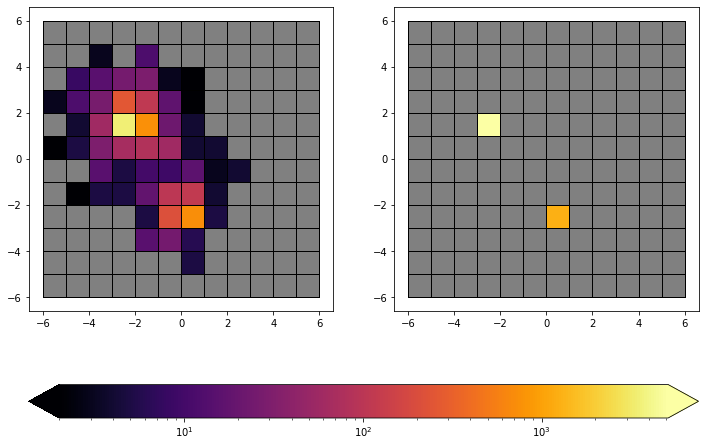

In [6]:
event_number = 12
true_event = np.exp(input_merged[event_number]*11)
ml_event = np.exp(answers_merged[event_number]*11)
ml_event[ml_event<2] = 0
true_event[true_event<1.5] = 0
display_event_comparison(true_event, ml_event)
print(f"max true {np.max(true_event)} max eval {np.max(ml_event)}")
print(f"sum true {np.sum(true_event)} sum eval {np.sum(ml_event)}")

(<Figure size 864x648 with 3 Axes>, <AxesSubplot:>, <AxesSubplot:>)

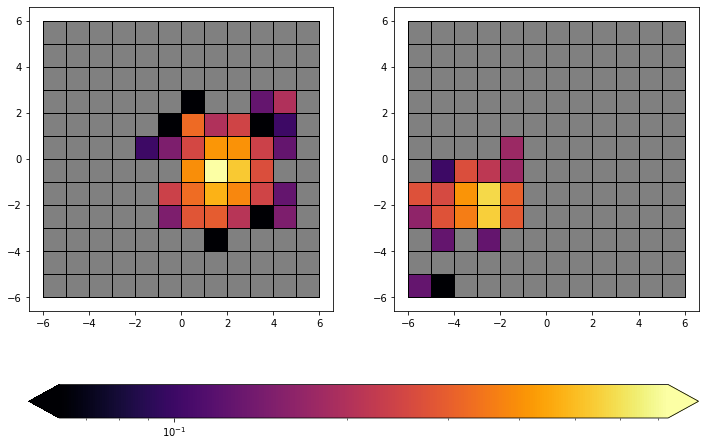

In [7]:
display_event_comparison(input_first[1], input_second[1])

(<Figure size 864x648 with 3 Axes>, <AxesSubplot:>, <AxesSubplot:>)

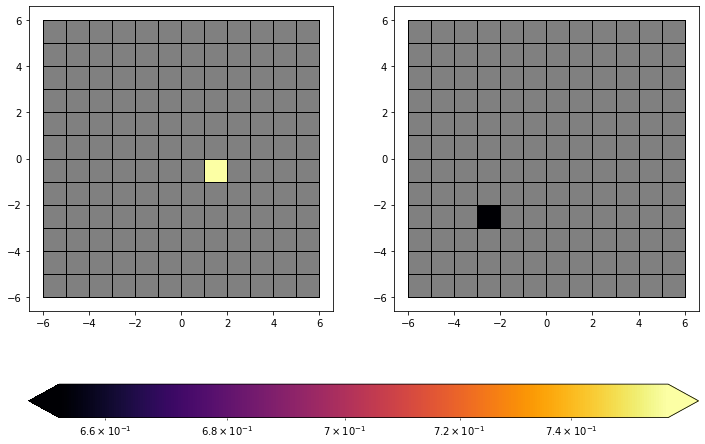

In [8]:
display_event_comparison(answers_first[1], answers_second[1])

In [11]:
# How to get the cell ids
col = np.argmax(np.argmax(answers_first[1], axis=1)) - 1
row = np.argmax(np.argmax(answers_first[1], axis=0)) - 1
print(row, col)



5 2


In [10]:
# removing events 1
a = np.array([1, 2, 3, 4, 5])
b = np.array([True, False, False, False, True])
a[b]


array([1, 5])